# Variational AutoEncoder

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import norm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

c:\Users\jaeyo\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, hidden_dim)
        self.linear_mu = nn.Linear(hidden_dim, latent_dim)
        self.linear_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = self.linear(x)
        h = F.relu(h)
        mu = self.linear_mu(h)
        logvar = self.linear_logvar(h)
        sigma = torch.exp(0.5 * logvar)

        return mu, sigma

In [3]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()
        self.linear1 = nn.Linear(latent_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = self.linear1(z)
        h = F.relu(h)
        h = self.linear2(h)
        x_hat = F.sigmoid(h)

        return x_hat

In [4]:
def reparameterize(mu, sigma):
    eps = torch.randn_like(sigma)
    z = mu + eps * sigma
    return z


class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def get_loss(self, x):
        mu, sigma = self.encoder(x)
        z = reparameterize(mu, sigma)
        x_hat = self.decoder(z)

        batch_size = len(x)
        L1 = F.mse_loss(x_hat, x, reduction='sum')
        L2 = - torch.sum(1 + torch.log(sigma ** 2) - mu ** 2 - sigma ** 2)

        return (L1 + L2) / batch_size

54.12272893676758
45.05532139485677
43.020097365315756
41.94546968383789
41.254170469156904
40.79738267211914
40.5157202331543
40.24760752970378
40.05186464233398
39.86195770060221
39.781587679036456
39.64476522420247
39.52869699503581
39.45063740641276
39.367589956665036
39.296905389404294
39.24119155883789
39.136058270263675
39.1024717976888
39.02859486897786
38.98556592305501
38.94361289876302
38.864309569295244
38.836895395914716
38.78012274576823
38.74930473327637
38.695445056152344
38.65211009724935
38.64865116780599
38.56985816040039


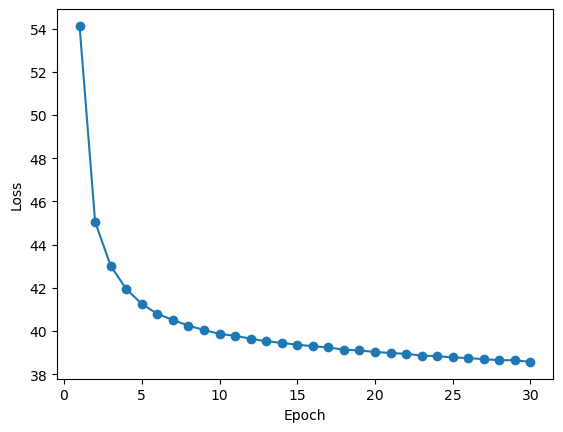

In [5]:
# hyperparameters
input_dim = 784   # data dimension
hidden_dim = 200  # neurons in hidden layers
latent_dim = 20   # latent dimension
epochs = 30
learning_rate = 3e-4
batch_size = 32


# datasets
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(torch.flatten)   # flatten
            ])
dataset = datasets.MNIST(
                root='./data',
                train=True,
                download=True,
                transform=transform
            )
dataloader = torch.utils.data.DataLoader(
                dataset,
                batch_size=batch_size,
                shuffle=True
            )

model = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
losses = []


for epoch in range(epochs):
    loss_sum = 0.0
    cnt = 0

    for x, label in dataloader:
        optimizer.zero_grad()
        loss = model.get_loss(x)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1

    loss_avg = loss_sum / cnt
    print(loss_avg)
    losses.append(loss_avg)


# plot losses
epochs = list(range(1, epochs + 1))
plt.plot(epochs, losses, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

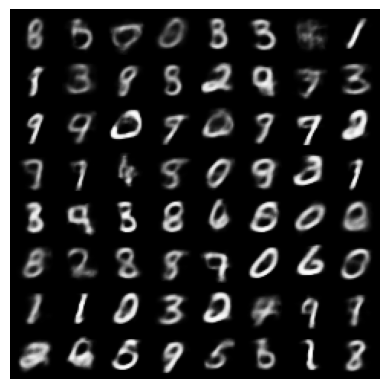

In [6]:
# generate new images
with torch.no_grad():
    sample_size = 64
    z = torch.randn(sample_size, latent_dim)
    x = model.decoder(z)
    generated_images = x.view(sample_size, 1, 28, 28)

grid_img = torchvision.utils.make_grid(generated_images, nrow=8, padding=2, normalize=True)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()